# Práctica 6: Análisis de Componentes Principales (PCA)
### Autores: David Jiménez Omeñaca
### Versión 1.0
### Fecha: 15-3-2024

---


In [1]:
from packaging import version

import sklearn

# en Google Colab?
try:
    import google.colab  # type:ignore

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# sklearn >= 1.3?
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("1.3"):
    if IN_COLAB:
        print("Instalando scikit-learn version >= 1.3. ...")
        %pip uninstall scikit-learn -y
        %pip install -U scikit-learn
    else:
        msg = "Por favor, actualiza manualmente la versión de scikit-learn a >= 1.3 en tu entorno virtual."
        raise ImportError(msg)
else:
    print(f"La versión de scikit-learn ({sklearn_version}) es suficiente (>= 1.3).")

La versión de scikit-learn (1.6.1) es suficiente (>= 1.3).


Como de costumbre, primero importamos las librerías y funciones/clases que emplearemos en la práctica:

In [2]:
from time import perf_counter

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
from sklearn.model_selection import (
    ValidationCurveDisplay,  # type: ignore
    train_test_split,
)

# descomenta %matplotlib qt si prefieres plots interactivos
%matplotlib inline
# %matplotlib qt

## 0. Carga de datos

En esta práctica vamos a emplear la base de datos [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist). <br>
Su formato es el mismo a *MNIST*, pero en vez dígitos, nuestro objetivo es clasificar prendas de ropa.

En primer lugar, cargamos Fashion-MNIST en la RAM:

In [3]:
# El dataset puede encontrarse en:
# https://github.com/zalandoresearch/fashion-mnist
# Para mayor facilidad, vamos a cargarlo directamente de:
# https://www.openml.org/search?type=data&sort=runs&id=40996&status=active
fashion_mnist = fetch_openml("Fashion-MNIST", parser="pandas")

# numpy ndarrays con las features y el target
X = fashion_mnist.data.values / 255  # (70000, 784=28x28) en [0, 1]
y = fashion_mnist.target.values.astype(int)  # (70000,) en [0, 9]

# el dataset está estructurado de tal forma que las primeras 60.000 instancias
# (imágenes) son de entrenamiento y las últimas 10.000 de test:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=int(1e4), shuffle=False
)

# En Fashion-MNIST, cada valor númerico se corresponde con una prenda. Usaremos el
# siguiente diccionario para el mapeo número -> prenda:
target_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

# o si las preferimos recuperar en español:
target_names_esp = {
    0: "Camiseta",
    1: "Pantalón",
    2: "Suéter",
    3: "Vestido",
    4: "Abrigo",
    5: "Sandalia",
    6: "Camisa",
    7: "Zapatilla",
    8: "Bolso",
    9: "Bota",
}

Vamos a explorar brevemente el dataset para hacernos una idea de su contenido:

In [4]:
unique, counts = np.unique(y_train, return_counts=True)
print(f"{'Prenda':20} #Imágenes")
print("-" * 30)
for u, c in zip(unique, counts):
    print(f"{target_names_esp[u]:25}{c}")

Prenda               #Imágenes
------------------------------
Camiseta                 6000
Pantalón                 6000
Suéter                   6000
Vestido                  6000
Abrigo                   6000
Sandalia                 6000
Camisa                   6000
Zapatilla                6000
Bolso                    6000
Bota                     6000


Vamos a definir una función que nos permita visualizar una muestra de imágenes del dataset:

In [5]:
def visualize_subset_in_grid(
    images,
    labels,
    predicted_labels=None,
    subset=25,
    esp=True,
    random=True,
    ncols=None,
    fig=None,
    ax=None,
):
    """Visualiza un subset de imágenes en una cuadrícula.

    Args:
        images: (n, 784) array con n imágenes 28x28 de Fasion-MNIST.
        labels: (n,) array con las etiquetas (numéricas) de las n imágenes.
        predicted_labels: (n,) array con las etiquetas predichas por un modelo.
        subset: Si es un integer, número de imágenes a visualizar, si es una secuencia
            de enteros, visualiza las imágenes con esos índices.
        esp: Si True, las etiquetas se mostrarán en español.
        random: Si True y subset es un entero, las imágenes se seleccionarán
            aleatoriamente.
        ncols: Número de columnas de la cuadrícula. Si es None, se usará una grid
            cuadrada.
        fig: Figura de matplotlib en la que visualizar las imágenes. Si es None, se
            creará una nueva figura.
        ax: Array de ejes de matplotlib en los que visualizar las imágenes. Si es None,
            se crearán nuevos ejes.
    """
    assert images.shape[1] == 784, "Las imágenes deben ser de 28x28 píxeles."
    assert len(images) == len(labels), "#imagenes debe coincidir con el de labels."

    if isinstance(subset, int):
        if random:
            subset = np.random.choice(images.shape[0], subset, replace=False)
        else:
            subset = np.arange(subset)

    n = len(subset)
    if ncols is None:
        ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))

    def get_title_and_color(i):
        if predicted_labels is None:
            if isinstance(labels[i], str):
                return labels[i], {"color": "black"}
            else:
                return names[labels[i]], {"color": "black"}

        is_correct = labels[i] == predicted_labels[i]
        symbol = (
            f"\N{HEAVY CHECK MARK}" if is_correct else f"\N{HEAVY MULTIPLICATION X}"
        )
        title = f"{names[labels[i]]}/{names[predicted_labels[i]]} {symbol}"
        color = "green" if labels[i] == predicted_labels[i] else "red"
        return title, {"color": color}

    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    names = target_names_esp if esp else target_names
    for i, axi in zip(subset, ax.ravel()):
        axi.imshow(images[i].reshape(28, 28), cmap="gray")
        axi.set_title(*get_title_and_color(i))
        axi.axis("off")
    fig.tight_layout()

Por cada ejecución de la siguiente celda se visualizan distintas muestras de Fashion-MNIST.

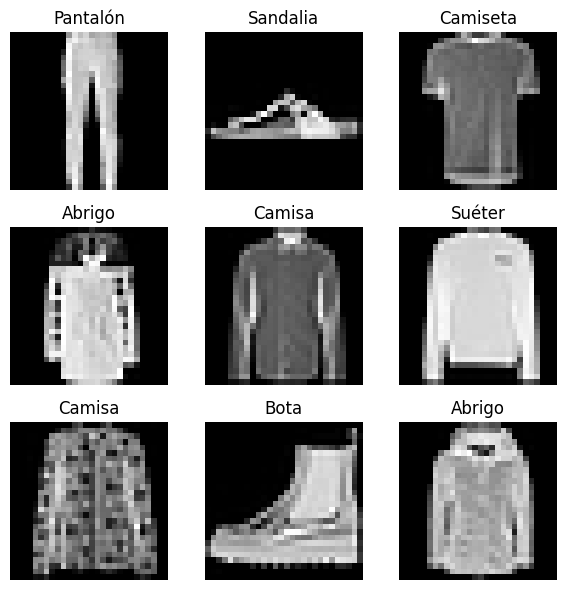

In [6]:
# visualizar un subset de las imágenes
visualize_subset_in_grid(X_train, y_train, subset=9, random=True)

## 1. Preparación de nuestro clasificador (Práctica 5)

Antes de aplicar **PCA** a Fashion-MNIST, a modo de referencia, vamos a crear un <br/>
clasificador Bayesiano "base", tal y como se hizo en la Práctica 5, pero <br/>
particularizándolo a las estadísticas de **Fashion-MNIST**.

Este modelo, entrenado con los datos originales, nos servirá para comparar y comprobar <br/>
la eficacia de **PCA** en la reducción de dimensionalidad.

Primero definimos algunas funciones auxiliares que nos servirán para evaluar los clasificadores...

In [7]:
def evaluar_clasificador(
    clf,
    X_train,
    y_train,
    X_test,
    y_test,
    do_report=True,
    do_cm=True,
    display_labels=None,
):
    """Evaluación de un clasificador.

    Args:
        clf: Clasificador a evaluar.
        X_train, y_train: Conjunto de entrenamiento.
        X_test, y_test: Conjunto de test.
        do_report: Si True, se muestra el report de clasificación.
        do_cm: Si True, se muestra la matriz de confusión.
        display_labels: Nombres de las clases para mostrar en la matriz de confusión.

    Returns:
        Diccionario con los resultados de la evaluación:
            - Tiempo de entrenamiento.
            - Accuracy en el conjunto de entrenamiento.
            - Accuracy en el conjunto de test.
    """
    # tiempo de entrenamiento
    t0 = perf_counter()
    clf.fit(X_train, y_train)
    t1 = perf_counter()
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    if do_cm:
        # matriz de confusión
        cm_display = ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, display_labels=display_labels, xticks_rotation=60.0
        )
        cm_display.ax_.set_title(repr(clf))
    if do_report:
        # report de clasificación
        print(
            classification_report(y_test, y_pred, target_names=display_labels, digits=2)
        )
    # recopilamos algunos resultados para reportarlos en otra función.
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred)
    results = {
        "Tiempo train (sec.)": t1 - t0,
        "Acc. (train)": acc_train,
        "Acc. (test)": acc_test,
    }
    return results


def evaluar_clasificadores(clfs, X_train, y_train, X_test, y_test):
    """Evaluación de varios clasificadores."""
    assert iter(clfs), "clfs debe ser un iterable de clasificadores."
    display_labels = list(target_names_esp.values())
    all_results = {}
    name_mlen = 0
    for clf in clfs:
        name = repr(clf)
        print(f"\n{name}:\n{'-' * (len(name) + 1)}")
        all_results[name] = evaluar_clasificador(
            clf, X_train, y_train, X_test, y_test, display_labels=display_labels
        )
        name_mlen = max(name_mlen, len(name))

    # reporte global de precisión y tiempo de entrenamiento
    headers = [f"{'Modelo':<{name_mlen}}"] + [
        f"{k:>{len(k)}}" for k in all_results[name].keys()
    ]
    print("\n" + "  ".join(headers))
    print("-" * len("  ".join(headers)))
    for name, results in all_results.items():
        row = [f"{name:<{name_mlen}}"] + [
            f"{v:>{len(k)}.2f}" for k, v in results.items()
        ]
        print("  ".join(row))
    print()

La siguiente celda instancia el *clasficador que emplearemos* en el resto de la práctica:

In [8]:
clf = LinearDiscriminantAnalysis(shrinkage=0.001, solver="lsqr")

Entrenamos este modelo con los datos originales:

{'Tiempo train (sec.)': 2.024510699999155,
 'Acc. (train)': 0.8322666666666667,
 'Acc. (test)': 0.8148}

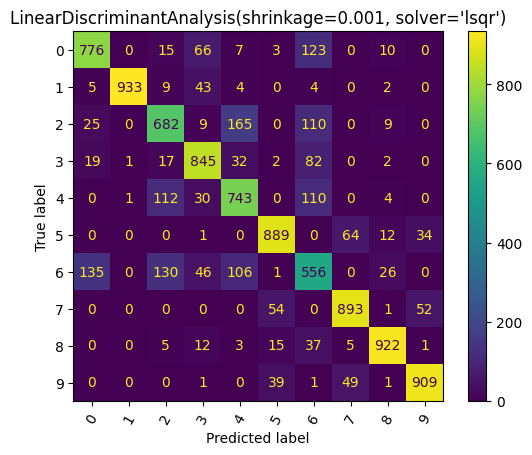

In [9]:
evaluar_clasificador(clf, X_train, y_train, X_test, y_test, do_report=False, do_cm=True)

## 2. Análisis de Componentes Principales (PCA)

Visualizamos las primeras y últimas 6 componentes principales utilizando el algoritmo PCA.

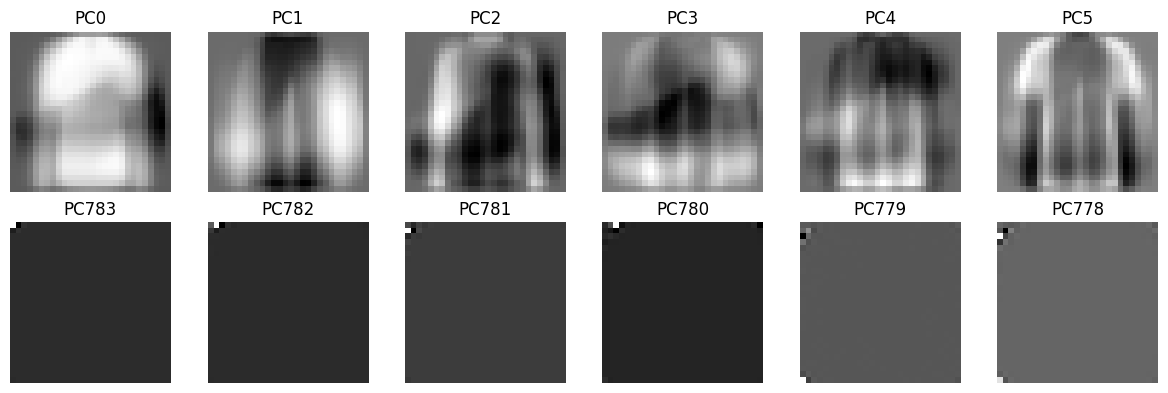

In [10]:
# Get all the pca components 
pca = PCA()

# Fit the PCA model with the training data
pca.fit_transform(X_train)

length = len(pca.explained_variance_ratio_)
pca_selected_index = [0,1,2,3,4,5,length-1,length-2,length-3,length-4,length-5,length-6]
pca_selected_labels = [f"PC{i}" for i in range(0, pca.components_.shape[0])]

# Plot the explained variance ratio
visualize_subset_in_grid(
    pca.components_,
    pca_selected_labels,
    subset = pca_selected_index,
    ncols=6,
)

Aquí, podemos apreciar:
- Las 6 primeras componentes están capturando la variabilidad de las diferentes prendas
- Las 6 últimas, están capturando ruido.
Esto nos está indicando que es posible que no todas las componentes sean necesarias para nuestro estudio.

### 2.1 a) ¿Con cuántas de las 784 componentes te puedes quedar sin alterar los resultados de la clasificación?
Para obtener el número de componentes útiles, primero vamos a ajustar el modelo con diferente número de componentes y vamos a buscar cuando se obtiene un accuracy similar al obtenido con todas las componentes.

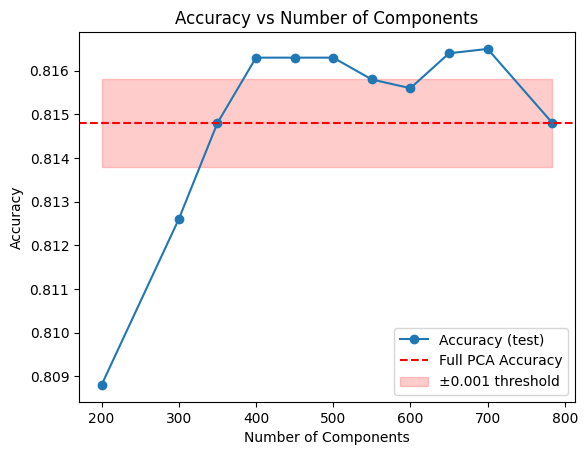

El accuracy del modelo con todas las componentes es 0.8148
[0.8088, 0.8126, 0.8148, 0.8163, 0.8163, 0.8163, 0.8158, 0.8156, 0.8164, 0.8165, 0.8148]


In [11]:
def plot_accuracy_different_components(X_train, X_test, y_train, y_test, selected_components, threshold=0.001):

    X_train_all = pca.transform(X_train)
    X_test_all = pca.transform(X_test)

    X_train_transformed = [X_train_all[:, :i] for i in selected_components]
    X_test_transformed = [X_test_all[:, :i] for i in selected_components]


    results = [evaluar_clasificador(clf, X_train_transformed[i], y_train, X_test_transformed[i], y_test, do_report=False, do_cm=False) 
               for i in range(len(selected_components))]
    
    results_all = evaluar_clasificador(clf, X_train_all, y_train, X_test_all, y_test, do_report=False, do_cm=False)

    # Extract test accuracies
    test_accuracies = [r["Acc. (test)"] for r in results]
    reference_accuracy = results_all["Acc. (test)"]

    # Plot the accuracy vs. number of components
    fig, ax = plt.subplots()
    ax.plot(selected_components, test_accuracies, marker="o", label="Accuracy (test)")

    # Add horizontal line for reference accuracy
    ax.axhline(reference_accuracy, color="red", linestyle="--", label="Full PCA Accuracy")

    # Fill the threshold region
    ax.fill_between(selected_components, reference_accuracy - threshold, reference_accuracy + threshold, 
                    color="red", alpha=0.2, label=f"±{threshold:.3f} threshold")

    # Annotate final accuracy
    ax.annotate(f"Acc.test {reference_accuracy:.2f}", 
                (selected_components[-1], reference_accuracy + 0.03), 
                color="red", fontsize=10)

    ax.set_xlabel("Number of Components")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy vs Number of Components")
    ax.legend()
    plt.show()
    return results, results_all

result, goal_result = plot_accuracy_different_components(X_train, X_test, y_train, y_test, [200, 300, 350, 400, 450, 500, 550, 600, 650, 700, 784])

result_accuracy, goal_accuracy = [r["Acc. (test)"] for r in result], goal_result["Acc. (test)"]

print(f"El accuracy del modelo con todas las componentes es {goal_accuracy}")

print(result_accuracy)


Aquí, extraemos una serie de conclusiones:
- Al aumentar el número de componentes, como era de esperar, el accuracy aumenta hasta un punto que empieza a oscilar
- Estas oscilaciones se deben en parte a la regularización. A mayor número de componentes, más dimensiones son regularizadas, afectando así a la precisión. Por esto, se obtiener mejores resultados con menos componentes.
- Por cómo se comporta la gráfica, se ha decidido quedarse con $350$ componentes, ya que así, el resultado general no se altera. Esto supone una reducción de más del $50\%$ de las dimensiones originales.

### 2.1 b) Si reduces las dimensiones de los datos para mantener el 99% de la variabilidad, ¿qué tan buenos son los resultados de la clasificación?

Otra forma de obtener un buen valor en la práctica, es encontrar el $k$ tal que:
$$
\frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^n \lambda_i} > 0.99
$$
Esto es lo que se conoce como varianza explicada.

Ploteamos la varianza explicada considerando las diferentes componentes para obtener el model más reducido que asegura el 99 de la variabilidad.

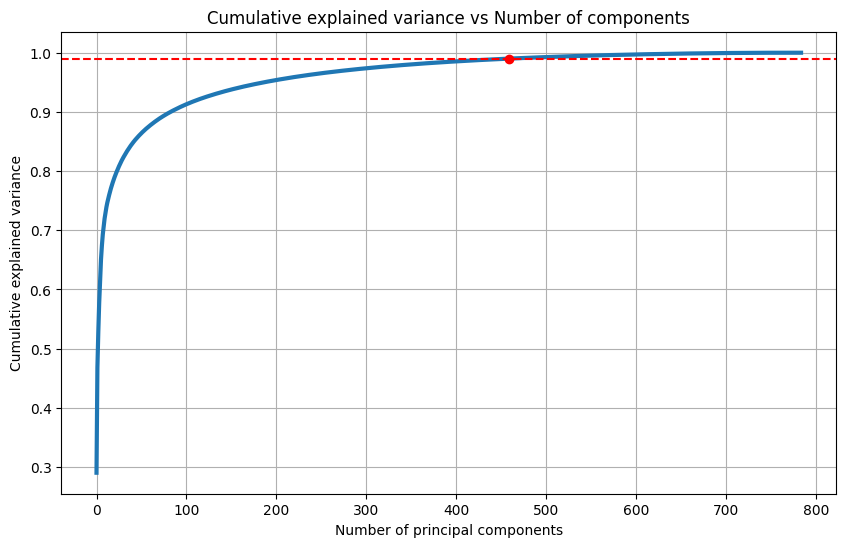

Se necesitan 458 de 784 componentes principales para explicar el 95% de la varianza acumulada.


In [12]:
def plot_cummulative_variance(pca, prob_explained_variance=0.95):
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    min_index = np.min([i for i in range(len(cumsum)) if cumsum[i] >= prob_explained_variance])
    plt.figure(figsize=(10, 6))
    plt.plot(cumsum, linewidth=3)
    plt.axhline(prob_explained_variance, color="red", linestyle="--")
    plt.plot(min_index, cumsum[min_index], "ro")
    plt.xlabel("Number of principal components")
    plt.ylabel("Cumulative explained variance")
    plt.title("Cumulative explained variance vs Number of components")
    plt.grid()
    plt.show()
    return min_index

min_dim = plot_cummulative_variance(pca, 0.99)
cumsum = np.cumsum(pca.explained_variance_ratio_)

print(f"Se necesitan {min_dim} de {len(cumsum)} componentes principales para explicar el 95% de la varianza acumulada.")

Entrenando este nuevo modelo:

{'Tiempo train (sec.)': 1.466596300000674,
 'Acc. (train)': 0.8283333333333334,
 'Acc. (test)': 0.8166}

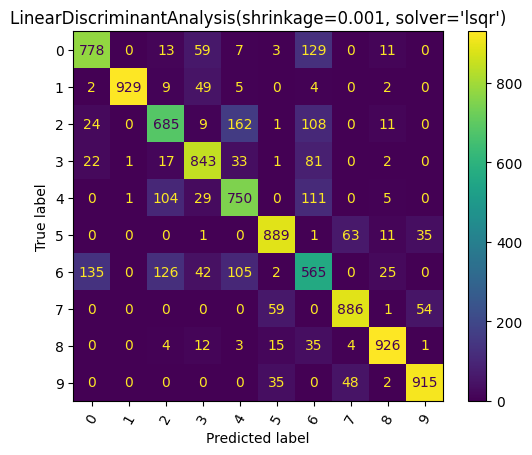

In [13]:
def results_model_number_components(n):
    X_train_all = pca.transform(X_train)
    X_test_all = pca.transform(X_test)

    X_train_transformed = X_train_all[:, :n]
    X_test_transformed = X_test_all[:, :n]

    return evaluar_clasificador(clf, X_train_transformed, y_train, X_test_transformed, y_test, do_report=False, do_cm=True)

results_model_number_components(min_dim)

Como conclusiones:
- Se obtiene un modelo similar al entrenado utilizando todas las componentes.
- Se ha reducido en más del $50\%$ el tiempo de entrenamiento.

Así, el método PCA nos ha permitido reducir las dimensiones de los problemas sin comprometer la precisión del modelo entrenado. 

### 2.1 c) Reconstruye alguna imagen del dataset de entrenamiento.

Reconstruimos algunas imágenes con diferents números de componentes analizando el PSNR para cada una de las reconstrucciones. El PSNR se calcula como:
$$
\text{PSNR} = 10 \log_{10} \left(\frac{L^2}{\text{MSE}}\right)
$$
donde:
$$
\text{MSE} = \frac{1}{m n} \sum_{i=1}^{m} \sum_{j=1}^{n} \left( I(i,j) - \hat{I}(i,j) \right)^2
$$

In [14]:
def calculate_psnr(imgs, reconstructed_imgs):
    """Peak Signal-to-Noise Ratio (PSNR) para batch de imágenes.

    Args:
        imgs: (n, d) array con n imágenes 28x28.
        reconstructed_imgs: (n, d) array con las imágenes reconstruidas.

    Returns:
        psnr: (n,) array con el PSNR de cada imagen reconstruida.
    """
    mse = np.mean((imgs - reconstructed_imgs) ** 2, axis=1)
    psnr = np.empty_like(mse)
    mask = mse == 0
    psnr[mask] = np.inf
    R2 = 1.0 if imgs.max() <= 1 + 1e-9 else 255**2 
    psnr[~mask] = 10 * np.log10(R2 / mse[~mask])
    return psnr

def show_reconstruction_vs_ncomponents(X, n_components=None, idx=None):
    if n_components is None:
        n_components = np.linspace(10, X.shape[1], 5).astype(int)
    if idx is None:
        idx = np.random.choice(len(X))

    fig, ax = plt.subplots(1, len(n_components) + 1, figsize=(15, 5))
    ax[0].imshow(X[idx].reshape(28, 28), cmap="gray")
    ax[0].set_title("Original")
    ax[0].axis("off")

    for i, nc in enumerate(n_components):
        pca = PCA(n_components=nc)
        X_transformed = pca.fit_transform(X)
        X_reconstructed = pca.inverse_transform(X_transformed)

        ax[i + 1].imshow(X_reconstructed[idx].reshape(28, 28), cmap="gray")
        
        psnr = calculate_psnr(X[idx].reshape(1, -1), X_reconstructed[idx].reshape(1, -1))

        ax[i + 1].set_title(f"{nc} PCs, PSNR={psnr[0]:.2f}")
        ax[i + 1].axis("off")

    fig.tight_layout()


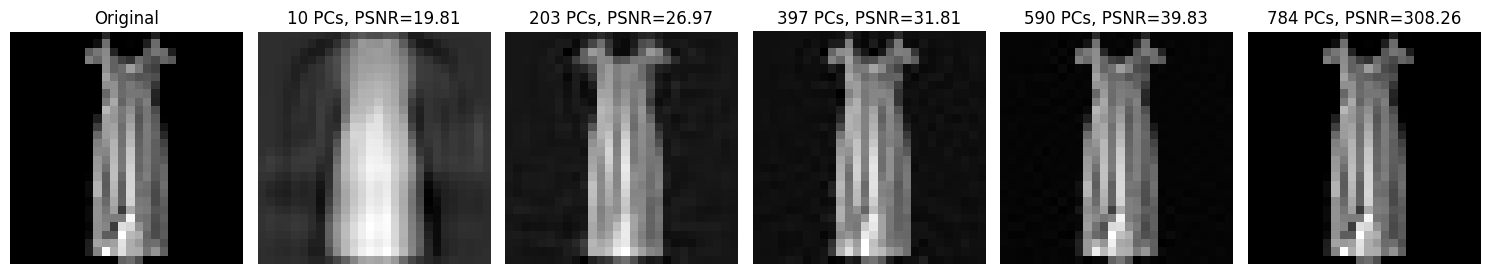

In [15]:
idx = None
n_components = np.linspace(10, X_train.shape[1], 5).astype(int)
show_reconstruction_vs_ncomponents(X_train, n_components, idx)

Concluimos que:
- Cuanto mayor número de componentes, más similares son las imágenes reduciendo el $MSE$. 
- Como el PSNR es inversamente proporcional al MSE, este aumenta cuando el número de componentes lo hace.

### 2. Filtrado de ruido en imágenes.

En esta última parte, vamos a analizar la utilidad de PCA para filtrar ruido Gaussiano en imágenes.

In [16]:
def add_noise_to_images(X, noise_std):
    """Añade ruido Gaussiano (centrado en 0) de magnitud `noise_std` a las imágenes ."""
    return np.clip(X + noise_std * np.random.randn(*X.shape), 0, 1)

El siguiente widget visualiza de forma interactiva como afecta el ruido a las imágenes de <br>
Fashion-MNIST, para diferentes valores de `noise_std`:

In [17]:
ncols = 3
subset = np.random.choice(len(X_train), 12, replace=False)
nrows = int(np.ceil(len(subset) / ncols))


@widgets.interact(noise_level=(0, 0.5, 0.01))
def display_images(noise_level=0.3):
    images = X_train[subset]
    images = add_noise_to_images(images, noise_level)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 1.5, nrows * 1.5))
    visualize_subset_in_grid(
        images, y_train[subset], subset=len(subset), fig=fig, ax=ax, random=False
    )
    plt.show()

interactive(children=(FloatSlider(value=0.3, description='noise_level', max=0.5, step=0.01), Output()), _dom_c…

#### 2. a) Utiliza PCA para eliminar el ruido de las imágenes.

En la siguiente celda, visualizamos de forma interactiva el *PSNR* de **todas** las imágenes reconstruidas <br>
con PCA, en función del número de componentes principales indicadas con el slider `n_components`. 

También se visualiza el filtrado de ruido para una imagen de forma interactiva <br> 
(seleccionada con el slider `idx`).

In [18]:
@widgets.interact(n_components=(4, 784, 10), idx=(0, len(X_train), 1), noise=(0.1, 1, 0.1))
def show_reconstruction_vs_ncomponents(n_components=784, idx=0, noise=0.1):
    """Visualización interactiva del filtrado de ruido con PCA."""
    X_train_noisy = add_noise_to_images(X_train, noise_std=noise)

    pca_full = PCA()
    pca_full.fit(X_train_noisy)
    components_full = pca_full.components_  # (n_components, 784)
    # reference PSNR values.
    psnr_noisy = calculate_psnr(X_train, X_train_noisy)
    min_noisy = np.min(psnr_noisy)
    max_noisy = np.max(psnr_noisy)
    
    # Monkey-patching para evitar calcular de nuevo los componentes principales.
    pca_full.components_ = components_full[:n_components]
    # imágenes filtradas con PCA y sus correspondientes PSNR.
    X_recon = pca_full.inverse_transform(pca_full.transform(X_train_noisy))

    psnr_pca = calculate_psnr(X_train, X_recon)  # (n,)
    binwidth = 0.1
    bins = np.arange(
        min(min_noisy, np.min(psnr_pca)),
        max(max_noisy, np.max(psnr_pca)) + binwidth,
        binwidth,
    )
    # visualización
    fig, ax = plt.subplots(2, 2, figsize=(5, 5))
    ax[0, 0].imshow(X_train[idx].reshape(28, 28), cmap="gray")
    ax[0, 0].set_title("Original")
    ax[0, 1].imshow(X_train_noisy[idx].reshape(28, 28), cmap="gray")
    ax[0, 1].set_title("Ruidosa")
    ax[1, 0].imshow(X_recon[idx].reshape(28, 28), cmap="gray")
    ax[1, 0].set_title("Filtrada")
    # psnr histograms
    ax[1, 1].hist(psnr_noisy, bins=bins, alpha=0.5, label="Ruidosa")
    ax[1, 1].hist(psnr_pca, bins=bins, alpha=0.5, label="Filtrada")
    ax[1, 1].set_xlabel("PSNR")
    ax[1, 1].legend()
    fig.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=784, description='n_components', max=784, min=4, step=10), IntSlider(val…

Llegamos a las siguientes conclusiones:
- Mientras el ruido no introduzca más variabilidad que la presente en las propias imágenes, las primeras componentes principales capturan principalmente la estructura de los datos.
- Si solo se consideran las primeras componentes, se reduce el impacto del ruido. 
- Si aumentamos la proporción de ruido, este introduce tanta variabilidad que empieza a dominar las primeras componentes principales, impidiendo que estas capturen correctamente las formas de las figuras. 
- Esto último sucede porque PCA no tiene conocimiento explícito de las figuras, sino que únicamente ordena las direcciones de mayor variabilidad en los datos.

Para verlo mejor, vamos a plotear la curva de error de reconstrución vs el número de componentes utilizadas para imágenes ruidosas:

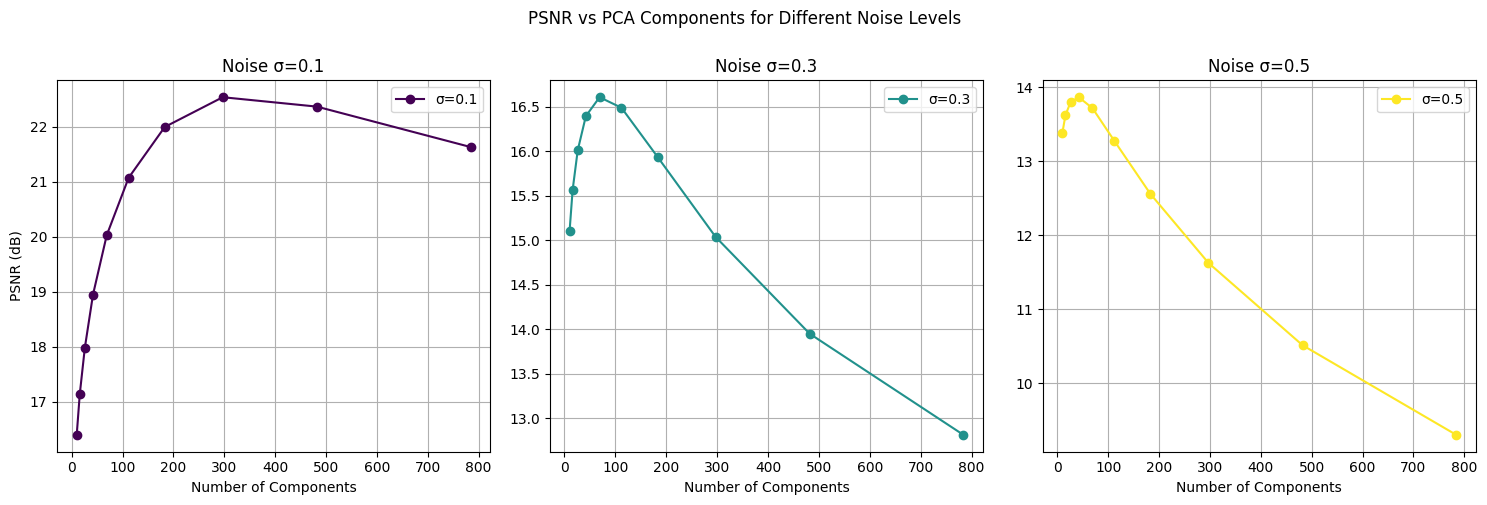

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_psnr_vs_components_multi(X_clean, noise_levels, components_grid):

    fig, axes = plt.subplots(1, len(noise_levels), figsize=(15, 5))
    fig.suptitle('PSNR vs PCA Components for Different Noise Levels', y=1)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(noise_levels)))
    
    for i, (noise_std, ax) in enumerate(zip(noise_levels, axes)):

        X_noisy = add_noise_to_images(X_clean, noise_std=noise_std)
        
        # Fit PCA
        pca = PCA()
        pca.fit(X_noisy)
        components_all = pca.components_
        
        psnr_values = []
        for n_components in components_grid:
            pca.components_ = components_all[:n_components]
            X_reconstructed = pca.inverse_transform(pca.transform(X_noisy))
            psnr = calculate_psnr(X_clean, X_reconstructed)
            psnr_values.append(np.mean(psnr))
        
        ax.plot(components_grid, psnr_values, marker='o', color=colors[i], 
               label=f'σ={noise_std:.1f}')
        ax.set_title(f'Noise σ={noise_std:.1f}')
        ax.set_xlabel('Number of Components')
        if i == 0:
            ax.set_ylabel('PSNR (dB)')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

exp_values = np.logspace(np.log10(10), np.log10(784), 10)
components_grid = np.unique(exp_values.astype(int)) 
noise_levels = [0.1, 0.3, 0.5]

# Generate plot
plot_psnr_vs_components_multi(X_train, noise_levels, components_grid)

Aquí:
- Cuando no hay casi ruido, este se explica en componentes ya avanzadas. Al considerarlas, ocurre una disminución del PSNR, lo que implica una menor similaridad con la imagen original.
- Al aumentar el ruido, cada vez, más componentes explican la varianza de este, haciendo que esta disminución sea más temprana.

Por otro lado, ploteamos la distribución de los valores singulares para diferentes ruidos.

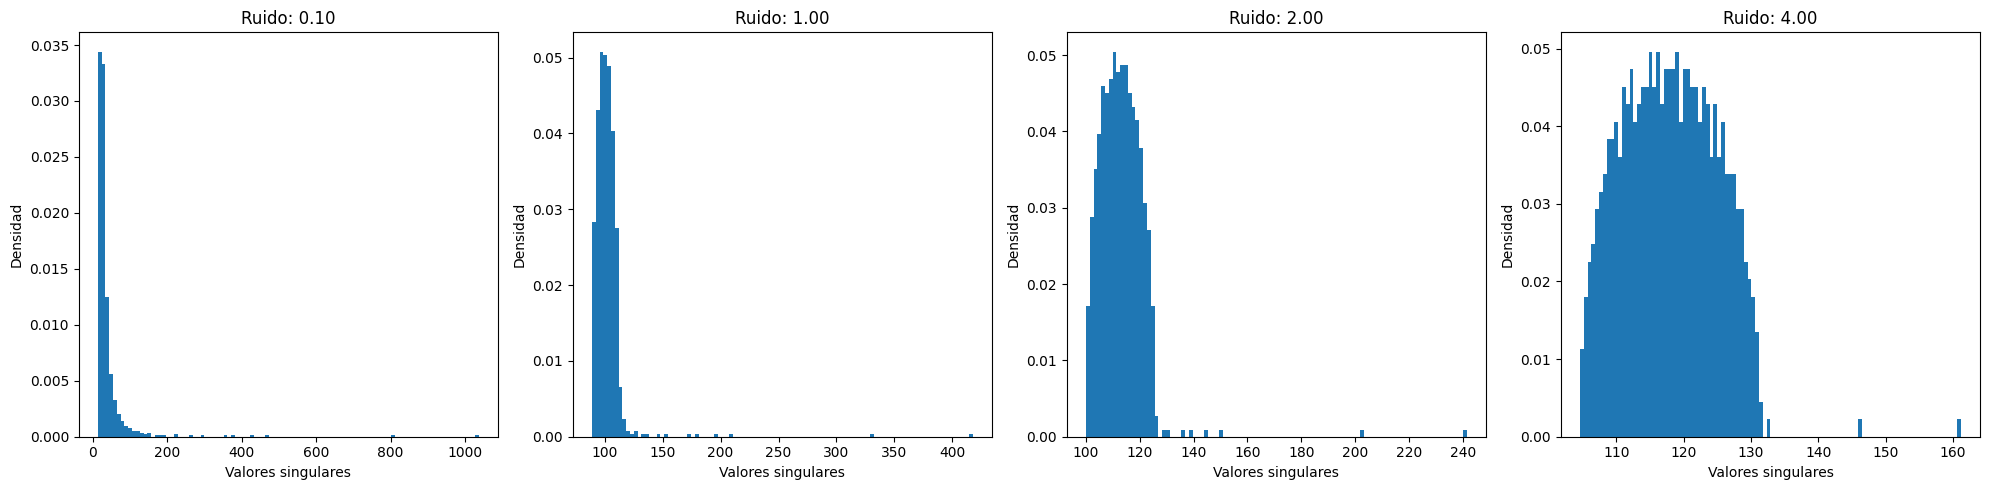

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_distribution_pca_singular_values_for_noise_levels(X, noise_levels, n_components=784):
    """Visualiza la distribución de los valores singulares de PCA para diferentes niveles de ruido."""
    fig, ax = plt.subplots(1, len(noise_levels), figsize=(5 * len(noise_levels), 5))
    for i, noise_level in enumerate(noise_levels):
        X_noisy = add_noise_to_images(X, noise_std=noise_level)
        pca = PCA(n_components=n_components)
        pca.fit(X_noisy)
        ax[i].hist(pca.singular_values_, bins=100, density=True)
        ax[i].set_title(f"Ruido: {noise_level:.2f}")
        ax[i].set_xlabel("Valores singulares")
        ax[i].set_ylabel("Densidad")
    fig.tight_layout()
    plt.show()


noise_levels = [0.1, 1, 2, 4]
plot_distribution_pca_singular_values_for_noise_levels(X_train, noise_levels, n_components=784)

Aquí:
- Cuando no hay casi ruido, hay valores propios muy grandes (800) que explican la variabilidad de las prendas, y, la mayoría, son pequeños, ya que no explican casi nada de variabilidad.
- Al aumentar el ruido, estos se van esparciendo por el espacio, ya que no hay patrones de variabilidad grandes entre las diferentes imágenes y todo es un "caos aleatorio" haciendo que los valores propios parezcan tomar una distribución uniforme en el espacio.

#### 2. c) Evalúa el clasificador Bayesiano en imágenes de test ruidosas y en el espacio PCA

Ahora, vamos a aplicar el modelo que hemos planteado anteriormente aplicado a los datos con un ruido significativo (desviación $\sigma=0.5$).

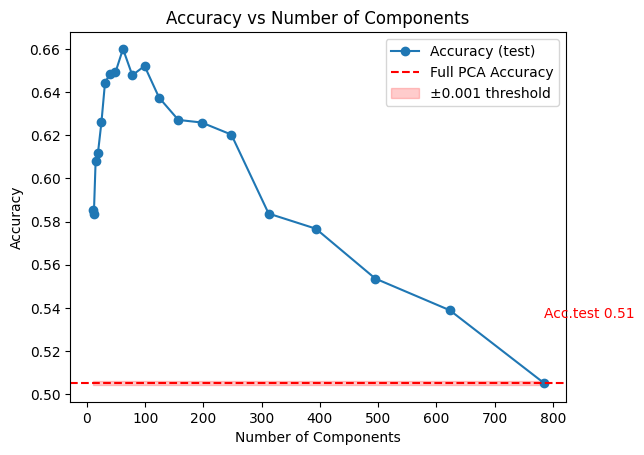

El accuracy del modelo con todas las componentes es 0.5053
El mejor accuracy se obtiene con 62 componentes principales y es 0.66


In [21]:
X_noisy_test = add_noise_to_images(X_test, noise_std=0.5)

exp_values = np.logspace(np.log10(10), np.log10(784), 20)
components_grid = np.unique(exp_values.astype(int)) # Ensure integers and uniqueness

result, goal_result = plot_accuracy_different_components(X_train, X_noisy_test, y_train, y_test, components_grid)

result_accuracy, goal_accuracy = [r["Acc. (test)"] for r in result], goal_result["Acc. (test)"]

print(f"El accuracy del modelo con todas las componentes es {goal_accuracy}")

print(f"El mejor accuracy se obtiene con {components_grid[np.argmax(result_accuracy)]} componentes principales y es {max(result_accuracy)}")


Esto nos indica que:
- Al añadir ruido, el método de PCA nos ayuda a aislarlo, pudiendo obtener mejores resultados con menos componentes, ya que no se está considerando este ruido para obtener las predicciones.
- Cuando se van añadiendo las componentes que explican la variabilidad del ruido, el ajuste empeora.

### 2.3. Interpretación visual de PCA $\to$ Visualización 3D
Ahora, vamos a utilizar las tres primeras componentes para poder visualizar los datos en 3D.

In [22]:
import io

from PIL import Image

# en Google Colab?
try:
    import google.colab  # type:ignore

    IN_COLAB = True
    from IPython.display import HTML, display
except ImportError:
    IN_COLAB = False

# k3d instalado?:
try:
    import k3d
except ImportError as e:
    print("Instalando K3D-jupyter...")
    if IN_COLAB:
        %pip install k3d
        import k3d
    else:
        print(
            "Por favor, instala K3D-jupyter en tu entorno virtual. Por ejemplo (en conda), con:\n"
            "conda install k3d -c conda-forge"
        )
        raise e


In [23]:
def plot_pca_3d(X, n_images, random=False):
    """Función auxiliar para visualizar un subset de imágenes en 3D usando PCA."""
    assert len(X) >= n_images, f"Solo hay {len(X)} imágenes en el dataset."
    pca_3d = PCA(n_components=3)
    pca_3d.fit(X)
    idx = (
        np.random.choice(len(X), n_images, replace=False)
        if random
        else np.arange(n_images)
    )
    subset = X[idx]
    subset_pca = pca_3d.transform(subset)  # (ns, n_components)
    subset_gray = (255 * subset).astype(np.uint8).reshape(-1, 28, 28)
    # transform to PIL images for later conversion to binary
    subset_pil = [Image.fromarray(subset_gray[i], mode="L") for i in range(len(subset))]

    # initialize plot
    plot = k3d.factory.plot(
        grid_visible=False,
        camera_mode="trackball",
        camera_auto_fit=False,
    )

    # add images as textures
    for i, im in enumerate(subset_pil):
        image_bytes = io.BytesIO()
        image_format = "PNG"  # or 'JPEG'
        im.save(image_bytes, format=image_format)
        im_bytes = image_bytes.getvalue()
        plt_texture = k3d.texture(
            im_bytes, file_format="png", translation=subset_pca[i]
        )
        plot += plt_texture

    # add origin coordinate frame
    scale = np.abs(subset_pca).mean()
    plot += k3d.vectors(
        np.zeros((3, 3), dtype=np.float32),
        scale * np.eye(3, dtype=np.float32),
        # [R, R, G, G, B, B]
        colors=[0xFF0000, 0xFF0000, 0x00FF00, 0x00FF00, 0x0000FF, 0x0000FF],
        labels=["X", "Y", "Z"],
        line_width=5e-2,
        head_size=3.0,
    )

    # set camera position
    # fmt:off
    plot.camera = [
        0.0, 0.0, 5.0 * scale, # xyz
        0.0, 0.0, 0.0,
        0.0, -1.0, 0.0,
    ]
    # fmt:on
    if IN_COLAB:
        plot.snapshot_type = "inline"
        display(HTML(plot.get_snapshot()))
    else:
        plot.display()
    return plot

In [24]:
plot = plot_pca_3d(X_train, 100, random=False)

c:\Users\david\Desktop\Automatic-Learning\Lab-01\venv\Lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

Para entender la posición de las diferentes imágenes, vamos a representar los vectores de las tres componentes como imágenes. Como estos toman valores positivos y negativos, vamos a representar en rojo los valores positivos y en azul los negativos, con punto medio blanco. 

Así, la coordenada $x$ será la combinación lineal de los valores representados en la componente $1$, por la imagen original (lo mismo para las coordenadas $y,z$ para las componentes $1,2$ respectivamente).

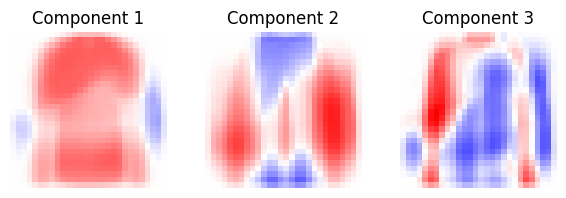

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap

def plot_3_components(X):
    """
    Plots the first 3 PCA components using a custom diverging colormap:
    - Negative values: Blue
    - Zero: White
    - Positive values: Red
    All components share the same scale.
    """
    # Fit PCA with 3 components
    pca_3d = PCA(n_components=3)
    pca_3d.fit(X)
    components = pca_3d.components_  # Shape: (3, 784)

    # Create a custom colormap: Blue -> White -> Red
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
    cmap = LinearSegmentedColormap.from_list('red_white_blue', colors, N=256)

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(6, 2))

    # Normalize all components to the same scale (symmetric around zero)
    abs_max = np.max(np.abs(components))
    norm = plt.Normalize(vmin=-abs_max, vmax=abs_max)

    for i, ax in enumerate(axes):
        # Reshape component to 28x28 image and plot with custom colormap
        component_img = components[i].reshape(28, 28)
        im = ax.imshow(component_img, cmap=cmap, norm=norm, interpolation='nearest')
        ax.set_title(f"Component {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


plot_3_components(X_train)

Las conclusiones son las siguientes:
- Los abrigos, camistas y similares tienen coordenadas $x$ positivas. Esto se debe a que la componente $1$ tiene un patrón de camiseta con valores positivos. Así, multiplicandolo por la imagen, salen valores positivos. Además
- Las botas, zapatillas y similares, tienen las $z$ negativas, ya que en la tercera componente hay un patrón de zapatilla con valores negativos. Además, en el eje $y$ es posible que sean positivas porque hay un patrón de zapatilla de valores positivos.
- Los pantalones, tienen un patrón negativo claro en la segunda componente, por lo que tendrán $y$ negativo.

Si ahora lo aplicamos sobre las imágenes ruidosas con ruido de $0.3$ y $5$:

Noise 0.3


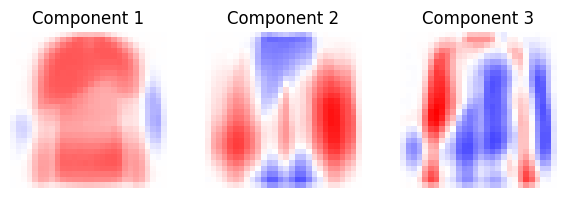

In [26]:
print("Noise 0.3")
plot_3_components(add_noise_to_images(X_train, 0.3))

Noise 5


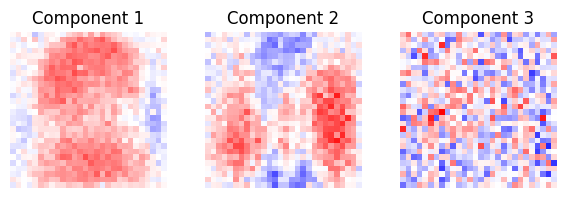

In [27]:
print("Noise 5")
plot_3_components(add_noise_to_images(X_train, 5))

Aquí se puede ver que:
- Para valores pequeños de ruido, la variabilidad del ruido no es suficiente para sobrepasar a la variabilidad de las prendas. Así, las primeras componentes permanecen casi intactas, afectando en menor medida a la posición 3D de las imágenes.
- Cuando el ruido es significativo, hasta las primeras componentes empiezan a explicar esta gran variabilidad, haciendo así que las posiciones sean ya inpredecibles.